# Evaluate the learnt value function on all states.


OLD DOCUMENTATION:

<small>
We want a good and a bad policy, and we'll evaluate the mixture of these policies.

At the start of the episode we pick one of the policies with prob `p` (and
the other with prob `1-p`), and stick to it for episode. Repeat and rinse.

We will evaluate different value estimation methods on this mixed policy. We will
see how well they approximate the true value (in the start state) of this mixed policy.
But for this, we need to know the true value of the mixed policy; thankfully this is
easy to calculate in our setting.

Each of these policies is deterministic, and the environment is deterministic. Therefore
we can easily find, by running the policies once, $V^{\pi_g}$, the value of the good policy in the start state, and $V^{\pi_b}$, the value of the bad policy in the start state.

The value of the mixed policy will be $p ^{\pi_g} + (1-p) ^{\pi_b}$.
</small>


In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import gymnasium as gym

import adaptive_time.utils
from adaptive_time import run_lib
from adaptive_time import environments
from adaptive_time.mc2 import phi_sa
from adaptive_time.run_lib import make_features

from pprint import pprint

In [2]:
adaptive_time.utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

In [3]:
seed = 13

run_lib.register_gym_envs()
env = gym.make('CartPole-OURS-v0')
env.stepTime(0.02)

run_lib.reset_randomness(seed, env)

pi_good = np.load('policy_to_eval_good.npy')
pi_bad = np.load('policy_to_eval_bad.npy')

class Policy:
    def __init__(self, sequence_action):
        self.sequence_action = sequence_action
        self.timestep = 0

    def __call__(self, *args, **kwargs):
        action = self.sequence_action[self.timestep]
        self.timestep = (self.timestep + 1) % len(self.sequence_action)
        return action

print('running good policy')
run_lib.reset_randomness(seed, env)
traj_good, early_term = environments.generate_trajectory(env, seed, Policy(pi_good))

print('running bad policy')
run_lib.reset_randomness(seed, env)
traj_bad, early_term = environments.generate_trajectory(env, seed, Policy(pi_bad))


def get_returns(trajectory, gamma = 0.99999):
    returns = []
    G = 0.0
    for t in range(len(trajectory)-1,-1,-1):
        traj = trajectory[t]
        _, _, r, _ = traj
        G = gamma * G + r
        returns.insert(0, G)
    return returns

returns_good = get_returns(traj_good)
returns_bad = get_returns(traj_bad)

print(returns_good)
print(returns_bad)

running good policy
running bad policy
[609.5992462873995, 608.605332340723, 607.6114084548075, 606.6178652875586, 605.6243121847788, 604.6319318963068, 603.6395615527774, 602.6492139416359, 601.6589477184976, 600.671668599202, 599.6846315065083, 598.6949300989098, 597.7055622444157, 596.7198226209439, 595.7347082302845, 594.7546797616283, 593.7757569690416, 592.8037249885543, 591.8335609020102, 590.8725931536586, 589.9146692505441, 588.9527137284384, 587.9809636467432, 587.0067546354519, 586.0255451166084, 585.0359473625979, 584.0435451612476, 583.0507159507613, 582.0566756681651, 581.0625351059828, 580.0686424836626, 579.0749262821413, 578.0828965594394, 577.0913447047965, 576.1030067556267, 575.1155489492911, 574.1260014406694, 573.1373922316873, 572.1470102913548, 571.1576103827044, 570.1666744319422, 569.1767637270302, 568.1854917852785, 567.1952986046387, 566.20387121153, 565.2135955242013, 564.222176104182, 563.2320093146858, 562.2407622341716, 561.250905625883, 560.260013885719

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.stepTime to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.stepTime` for environment variables or `env.get_wrapper_attr('stepTime')` that will search the reminding wrappers.
  logger.warn(


In [4]:
pickle.dump(
    {
        "good": {
            "returns": returns_good,
            "trajectory": traj_good,
        },
        "bad": {
            "returns": returns_bad,
            "trajectory": traj_bad,
        },
    }, open("true_value_estimate.pkl", "wb")
)

In [5]:
[obss_good, acts_good, rews_good, _] = [np.array(el) for el in list(zip(*traj_good))]
[obss_bad, acts_bad, rews_bad, _] = [np.array(el) for el in list(zip(*traj_bad))]

print(obss_good.shape, obss_bad.shape)

obss_diff = obss_good[:, None] - obss_bad[None, :]
print(obss_diff.shape)

# This checks which observations are the same between two trajectories
# NOTE: Since we have fixed initial state, we expect just [0, 0] to be the same
print(np.where(np.sum(obss_diff, axis=-1) == 0))

(616, 4) (37, 4)
(616, 37, 4)
(array([0]), array([0]))


In [6]:
print(np.where(np.sum(obss_good[:, None] - obss_good[None, :], axis=-1) == 0))
print(np.where(np.sum(obss_bad[:, None] - obss_bad[None, :], axis=-1) == 0))


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

## LOAD DATA

In [7]:
# run_name = "20240301-072040_policy_eval-all_states"
# run_name = "20240301-091719_policy_eval-all_states"
# run_name = "20240301-115352_policy_eval-all_states"

# run_name = "20240301-164740_policy_eval-all_states-bad_policy_only"
# exp_data = pickle.load(open("./exp_results/{}/exp_data.pkl".format(run_name), "rb"))


run_name = "exp_results/20240302-170639_u1_pred_no_reg/exp_data.pkl"
run_name = "exp_results/20240302-173630_u1_pred_orig_good/exp_data.pkl"
run_name = "exp_results/20240302-180544_u1_pred_orig_good/exp_data.pkl"
run_name = "exp_results/20240302-203006_u1_pred_sanity/exp_data.pkl"
run_name = "exp_results/20240302-204648_u1_pred_sanity/exp_data.pkl"
run_name = "exp_results/20240302-205221_u1_pred_sanity/exp_data.pkl"
run_name = "exp_results/20240302-210251_u1_pred_sanity/exp_data.pkl"  # < bad f_order=4
run_name = "exp_results/20240302-211935_u1_pred_sanity/exp_data.pkl"  # < bad f_order=1
run_name = "exp_results/20240302-212801_u1_pred_sanity/exp_data.pkl"  # < good f_order=4
run_name = "exp_results/20240302-213700_u1_pred_newgood/exp_data.pkl"  # < new, worse good (616 steps) f_order=4
run_name = "exp_results/20240302-215005_u1_pred_newgood/exp_data.pkl"  # < new, worse good (616 steps) f_order=5; diff ep has diff regularizers
run_name = "exp_results/20240302-221508_u1_pred_newgood/exp_data.pkl"  # < new, worse good (616 steps) f_order=5; diff ep has diff regularizers
run_name = "exp_results/20240303-210137_u1_pred_newgood/exp_data.pkl"  # < new, worse good (616 steps) f_order=2; diff ep has diff regularizers
run_name = "exp_results/20240303-212121_u1_pred_newgood/exp_data.pkl"  # < new, worse good (616 steps) f_order=2; diff ep has diff regularizers
run_name = "exp_results/20240303-212246_u1_pred_newgood/exp_data.pkl"  # < new, worse good (616 steps) f_order=0; diff ep has diff regularizers
run_name = "exp_results/20240303-213806_u1_pred_newgood/exp_data.pkl"  # < new, worse good (616 steps) f_order=4 new norm; diff ep has diff regularizers
run_name = "exp_results/20240303-224606_u1_pred_newgood/exp_data.pkl"  # < weird things, rerun.

with open(run_name, "rb") as f:
    exp_data = pickle.load(f)


In [8]:
exp_data["config"]

{'seed': 13,
 'save_limit': None,
 'termination_prob': 0,
 'max_env_steps': None,
 'epsilon': 0.0,
 'gamma': 0.99999,
 'fourier_order': 4,
 'do_weighing': True,
 'budget': 2,
 'budget_type': <BudgetType.EPISODES: 3>,
 'num_runs': 1,
 'tau': 0.02,
 'weights_to_evaluate': None,
 'policy_to_evaluate': ('policy_to_eval_good.npy',
  'policy_to_eval_bad.npy',
  1.0)}

In [9]:
print("Data keys:")
pprint(list(next(iter(exp_data["results"].values()))[0].keys()))

Data keys:
['total_return',
 'total_pivots',
 'total_interactions',
 'num_episode',
 'returns_per_episode_q',
 'predicted_returns_q',
 'returns_per_episode_v',
 'predicted_returns_v',
 'all_weights',
 'first_actions']


In [10]:
order = 4
if "fourier_order" in exp_data["config"]:
    order = exp_data["config"]["fourier_order"]
phi = make_features(order)

In [11]:
phis = {}

for obs, act in zip(obss_good, acts_good):
    phis[(*obs, act)] = phi_sa(phi.get_fourier_feature(obs), act)

for obs, act in zip(obss_bad, acts_bad):
    phis[(*obs, act)] = phi_sa(phi.get_fourier_feature(obs), act)

In [12]:
print(exp_data["results"].keys())
print(len(exp_data["results"]["u1"]))
print(exp_data["results"]["u1"][0]["num_episode"])
print([run_i["num_episode"] for run_i in exp_data["results"]["u1"]])

dict_keys(['u1', 'u5', 'u10', 'u20'])
1
[0, 1, 2]
[[0, 1, 2]]


In [13]:
import timeit
from tqdm.notebook import tqdm

# res is: variant -> data_over_runs.
#   data_over_runs is a list over episodes
#   each element in that list is [episode_idx, [pred_ret, emp_ret]]
res = {}   
# We also store the average empirical return for each episode,
# with the same structure as above.
avr_emp_ret = {}

# Similar structure to above, skipping episodes, see the error for 0 weights.
zero_weight_error = {}
# And storing the numbers of episodes.
num_episodes = {}

mix_p = exp_data["config"]["policy_to_evaluate"][2]
if mix_p not in [0, 0.5, 1]:
    raise ValueError("Mixing parameter not supported")

for variant in exp_data["results"]:
    print("Processing {}".format(variant))
    res.setdefault(variant, [])
    avr_emp_ret.setdefault(variant, [])
    zero_weight_error.setdefault(variant, [])
    num_episodes.setdefault(variant, [])

    for run_i in exp_data["results"][variant]:
        res[variant].append([])
        avr_emp_ret[variant].append([])
        zero_weight_error[variant].append([])
        first_actions = np.array(run_i["first_actions"])
        first_action_counts = np.cumsum(first_actions)

        num_episodes[variant] = run_i["num_episode"][-1]
        print(len(run_i["all_weights"]))
        assert len(run_i["all_weights"]) == num_episodes[variant]

        for it_i, weights in tqdm(enumerate(run_i["all_weights"])):
            rets = []

            if mix_p != 0:
                for timestep_i, (obs, act, emp_ret) in (enumerate(zip(obss_good, acts_good, returns_good))):
                    x_sa = phis[(*obs, act)]
                    pred_ret = x_sa.flatten() @ weights
                    rets.append([pred_ret, emp_ret])

            if mix_p != 1:
                for timestep_i, (obs, act, emp_ret) in (enumerate(zip(obss_bad, acts_bad, returns_bad))):
                    x_sa = phis[(*obs, act)]
                    pred_ret = x_sa.flatten() @ weights
                    rets.append([pred_ret, emp_ret])
            
            if timestep_i == 0 and mix_p != 0 and mix_p != 1:
                # estimate is based on number of first action seen
                first_action_weight = first_action_counts[it_i] / (it_i + 1)
                rets[0][0] = first_action_weight * rets[0][0] + (1 - first_action_weight) * rets[1][0]
                # empirical return is mixed            
                rets[0][1] = mix_p * rets[0][1] + (1 - mix_p) * rets[1][1]
    
            rets_ar = np.array(rets)
            res[variant][-1].append([
                it_i, rets_ar
            ])
            avr_emp_ret[variant][-1].append(np.mean(rets_ar[:, 1]))

Processing u1
2


0it [00:00, ?it/s]

Processing u5
2


0it [00:00, ?it/s]

Processing u10
2


0it [00:00, ?it/s]

Processing u20
2


0it [00:00, ?it/s]

In [14]:
res["u1"][0][0][1].shape  # [pred_ret, emp_ret] across all traj?


(616, 2)

In [15]:
exp_data["results"]["u1"][0]["total_interactions"]  # weights for each feature

[0, 616, 1232]

In [16]:
res["u1"][0][0]

[0,
 array([[ 6.10292668e+02,  6.09599246e+02],
        [ 6.08792648e+02,  6.08605332e+02],
        [ 6.07108780e+02,  6.07611408e+02],
        ...,
        [ 1.09132751e+00,  1.09136410e+00],
        [ 4.72758510e-01,  4.72759345e-01],
        [-9.11793904e-07,  0.00000000e+00]])]

In [17]:
# pickle.dump(
#     res, open("v_estimates_all_states-{}.pkl".format(run_name), "wb")
# )

In [18]:
print(res.keys())

dict_keys(['u1', 'u5', 'u10', 'u20'])


In [19]:
len(res['u1'][0][0])

2

Processing u1
Shape of returns array: (2, 616, 2)
predicted vs true return for first state: [610.29266786 609.59924629]
plotted_values (first its shape): (3,) [1.03366661 1.08695444 1.14024226]
Processing u5
Shape of returns array: (2, 616, 2)
predicted vs true return for first state: [609.59952126 609.59924629]
plotted_values (first its shape): (3,) [14348.04658407 14232.60116799 14117.1557519 ]
Processing u10
Shape of returns array: (2, 616, 2)
predicted vs true return for first state: [609.59924604 609.59924629]
plotted_values (first its shape): (3,) [25924.77700498 25508.48249177 25092.18797857]
Processing u20
Shape of returns array: (2, 616, 2)
predicted vs true return for first state: [609.59924629 609.59924629]
plotted_values (first its shape): (3,) [1939.26517439 1880.67823923 1822.09130407]


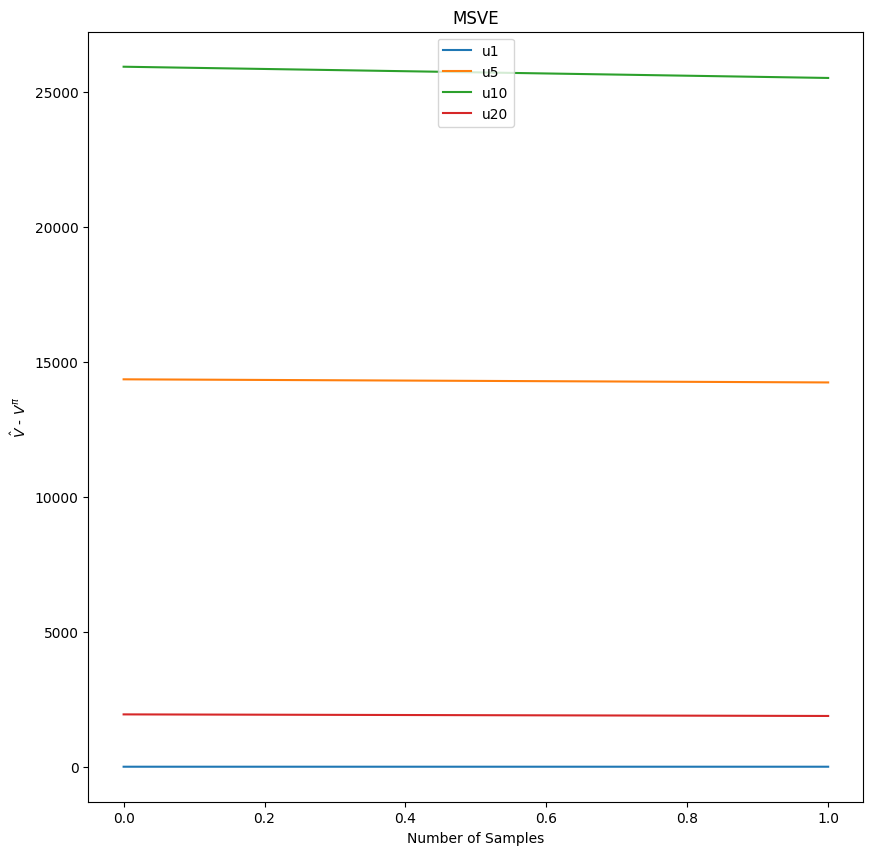


FOR SCALE:
average empirical returns:
 * u1 304.5302086063971
 * u5 304.5302086063971
 * u10 304.5302086063971
 * u20 304.5302086063971


In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

start_idx = 0
end_idx = -1   # 50

budget = exp_data["config"]["budget"]
for variant, runs in res.items():
    print("Processing {}".format(variant))

    interpolated_results = np.zeros((len(runs), budget + 1))
    for run_i, res_data in enumerate(runs):
        res_data = list(zip(*res_data))
        rets = np.array(res_data[1])

        print("Shape of returns array:", rets.shape)
        print("predicted vs true return for first state:", rets[0, 0])

        length = min(len(exp_data["results"][variant][run_i]["total_pivots"]), len(rets))

        interpolated_results[run_i] = np.interp(
            np.arange(budget + 1),
            exp_data["results"][variant][run_i]["total_pivots"][:length],
            np.mean(np.abs(rets[..., 0] - rets[..., 1]), axis=-1)[:length]
        )

    y_means = np.nanmean(interpolated_results, axis=0)
    print("plotted_values (first its shape):", y_means.shape, y_means)
    y_stderrs =  np.nanstd(interpolated_results, axis=0) / np.sqrt(len(runs))
    ax.plot(np.arange(budget + 1)[start_idx:end_idx], y_means[start_idx:end_idx], label=variant)
    ax.fill_between(np.arange(budget + 1)[start_idx:end_idx], (y_means - y_stderrs)[start_idx:end_idx], (y_means + y_stderrs)[start_idx:end_idx], alpha=0.1)


ax.legend()
ax.set_xlabel("Number of Samples")
ax.set_ylabel("$\hat V$ - $V^\pi$")
ax.set_title("MSVE")
# ax.set_ylim(0, ax.get_ylim()[1])
plt.show()

print()
print("FOR SCALE:")
print("average empirical returns:")
for k, v in avr_emp_ret.items():
    print(" *", k, v[0][0])  # Can hardcode first run, first episode, since all the same.


What are the predicted returns vs empirical returns along the trajectory?

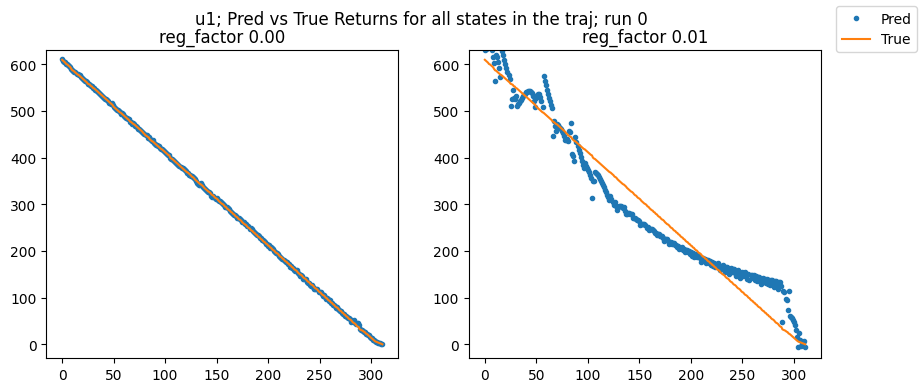

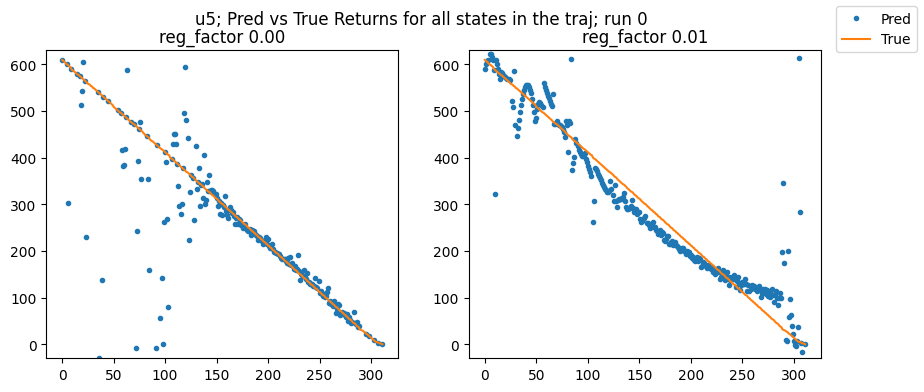

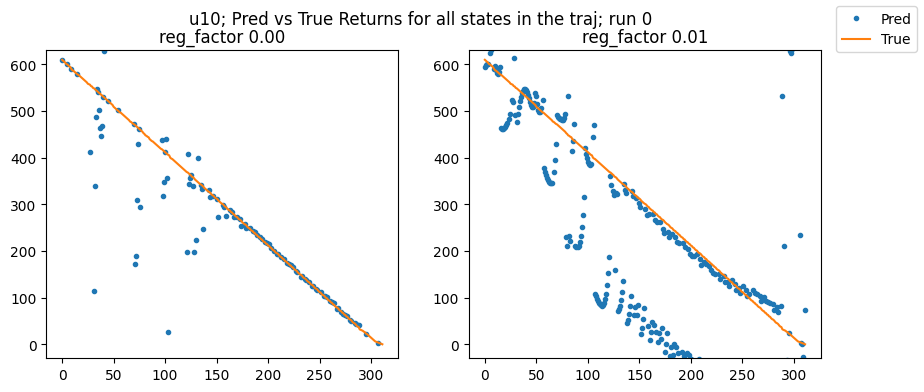

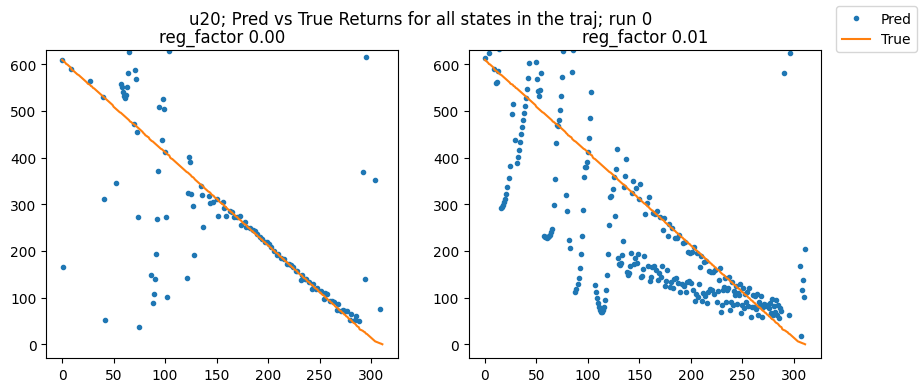

In [26]:
for variant in exp_data["results"].keys():
# variant = "u1"
    run_id = 0

    num_episodes = exp_data["results"][variant][run_id]["num_episode"][-1]

    num_rows = (num_episodes+1) // 2
    fig, ax = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows + 1),
                           sharex=True, sharey=False)

    axes = ax.flatten()

    for episode in range(num_episodes):
        pred_rets = res[variant][run_id][episode][1][:, 0]
        true_rets = res[variant][run_id][episode][1][:, 1]

        action = 0
        pred_rets = pred_rets[np.where(acts_good == action)]
        true_rets = true_rets[np.where(acts_good == action)]

        axes[episode].plot(pred_rets, label="Pred" if episode == 0 else None, linestyle="", marker=".")
        axes[episode].plot(true_rets, label="True" if episode == 0 else None, linestyle="-")
        # axes[episode].set_title(f"Episode {episode}")
        axes[episode].set_title(f"reg_factor {episode*0.01:.2f}")
        
        axes[episode].set_ylim(-30, 630)

    fig.legend()
    fig.suptitle(f"{variant}; Pred vs True Returns for all states in the traj; run {run_id}")
    plt.show()


Show off the number of pivots for each.

In [22]:
for variant, data in exp_data["results"].items():
    run_id = 0
    print(" *", variant, ":", data[0]["total_pivots"][1])


 * u1 : 616
 * u5 : 124
 * u10 : 62
 * u20 : 31


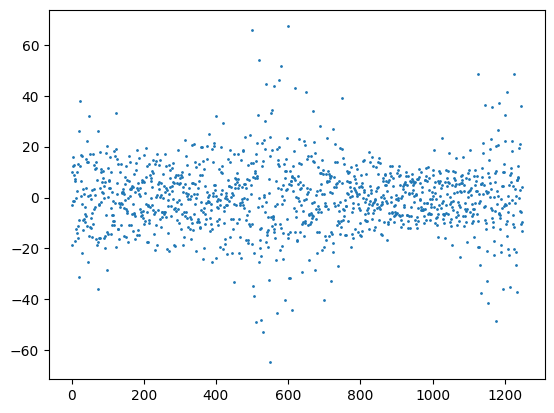

In [23]:
weights_to_check = exp_data["results"]["u10"][0]["all_weights"][1]
plt.scatter(range(len(weights_to_check)), weights_to_check, s=1)


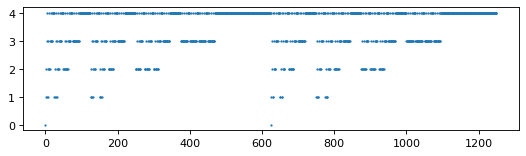

In [24]:
phi = make_features(exp_data["config"]["fourier_order"])
plt.figure(figsize=(8, 2), dpi=80)
plt.scatter(range(len(weights_to_check)),
            list(np.max(phi.order_list, axis=1)) * 2,
            s=1)

In [25]:

episode = 5

pred_rets = res[variant][run_id][episode][1][:, 0]
true_rets = res[variant][run_id][episode][1][:, 1]

plt.plot(pred_rets, label="Pred")
plt.plot(true_rets, label="True")
plt.legend()
plt.title(f"Predicted vs True Returns for all states; run {run_id}, episode {episode}")


IndexError: list index out of range

In [ ]:
print(variant)
print(exp_data["results"][variant][run_i]["total_pivots"])

u1
[0, 14874, 29748, 44622, 59496, 74370, 89244, 104118]


Processing u1


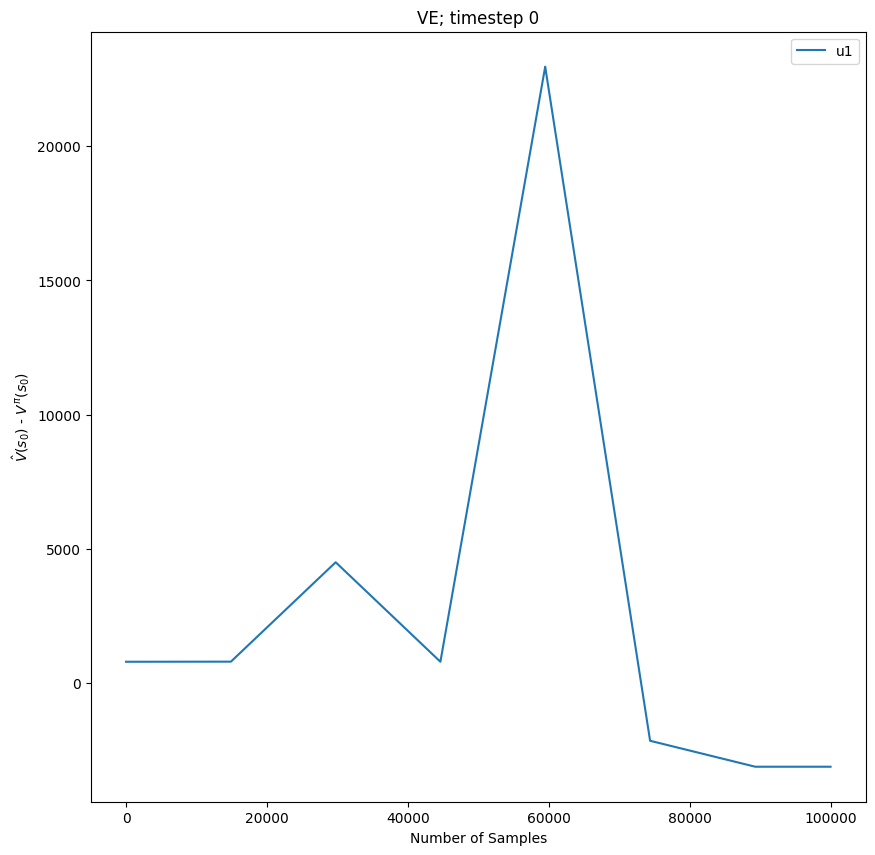

Processing u1


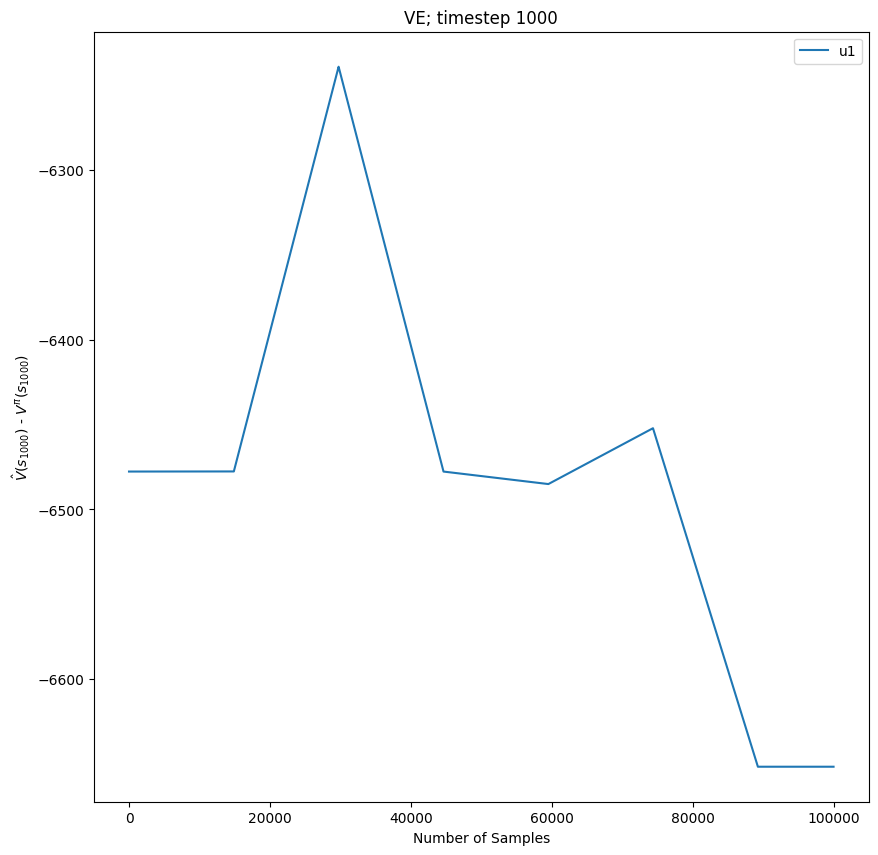

Processing u1


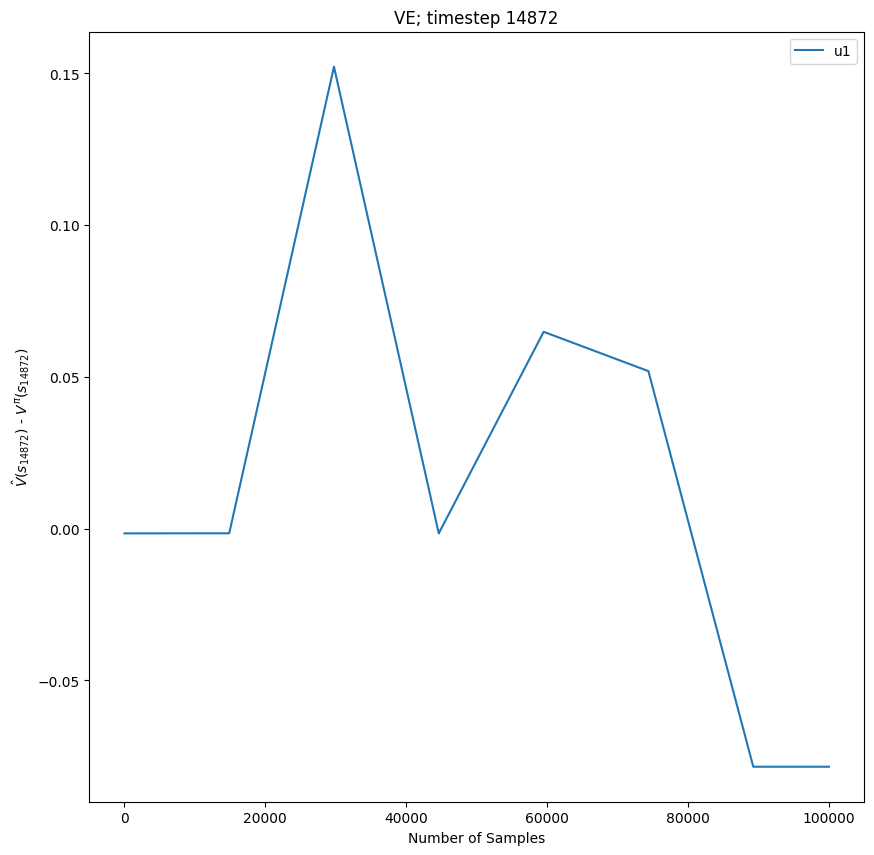

In [ ]:
budget = exp_data["config"]["budget"]


# total_num_timesteps = len(obss_good) + len(obss_bad) - 1
total_num_timesteps = next(iter(res.values()))[0][0][1].shape[0] - 1
timesteps_to_check = [0, 1000, total_num_timesteps - 1]
# timesteps_to_check = exp_data["results"]["u1"][0]["total_pivots"]

for timestep in timesteps_to_check:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for variant, runs in res.items():
        print("Processing {}".format(variant))

        interpolated_results = np.zeros((len(runs), budget + 1))
        for run_i, res_data in enumerate(runs):
            res_data = list(zip(*res_data))
            rets = np.array(res_data[1])

            length = min(len(exp_data["results"][variant][run_i]["total_pivots"]), len(rets))

            interpolated_results[run_i] = np.interp(
                np.arange(budget + 1),
                exp_data["results"][variant][run_i]["total_pivots"][:length],
                (rets[:, timestep, 0] - rets[:, timestep, 1])[:length]
            )

        y_means = np.nanmean(interpolated_results, axis=0)
        y_stderrs =  np.nanstd(interpolated_results, axis=0) / np.sqrt(len(runs))
        ax.plot(np.arange(budget + 1), y_means, label=variant)
        ax.fill_between(np.arange(budget + 1), y_means - y_stderrs, y_means + y_stderrs, alpha=0.1)

    ax.legend()
    ax.set_xlabel("Number of Samples")
    ax.set_ylabel("$\hat V(s_{{{timestep}}})$ - $V^\pi(s_{{{timestep}}})$".format(timestep=timestep))
    ax.set_title("VE; timestep {}".format(timestep))
    plt.show()


In [ ]:
res["u20"]

KeyError: 'u20'

In [ ]:
exp_data["results"]["u20"][0]["total_return"]